# Evidence curve as a function of time

This notebook examines how well the evidence curve can help us constrain the start time of a QNM. We consider an ideal case where a $(l=2,m=2,n=0)$ mode is injected into white noise.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as pl
import qnm_filter
import qnm
import copy

### Construct a signle QNM $(l=2,m=2,n=0)$

In [3]:
mass = qnm_filter.Filter.mass_unit(50) # in solar mass
omega, _, _ = qnm.modes_cache(s=-2, l=2, m=2, n=0)(a=0.69)

In [4]:
sampling_frequency = 16384 # in Hz
duration = 32 # in second
t_range = np.arange(-duration/2, duration/2, 1/sampling_frequency)
signal = t_range*0

We set the start time of this mode to be 0.

In [5]:
signal[t_range>0] = np.real(np.exp(-1j*omega*np.abs(t_range[t_range>0]/mass)))

### Construct detector noise with `bilby`

Make up a ACF for white noise and create a `Noise` instance. The first element of ACF is $\sigma^2$.

In [6]:
acf_time = np.arange(0, 1., 1./sampling_frequency)
acf_value = acf_time*0
acf_value[0] = 1e-4

In [7]:
noise_customize = qnm_filter.Noise(acf = acf_value, time = acf_time)
noise_customize.from_acf()

Construct two `bilby.gw.detector.Interferometer` instances for comparision, one is noisy and the other one is noiseless.

In [8]:
bilby_ifo = qnm_filter.set_bilby_ifo(noise_customize, sampling_frequency, duration, start_time=-duration/2)
bilby_ifo_no_noise = qnm_filter.set_bilby_ifo(noise_customize, sampling_frequency, duration, 
                                              start_time=-duration/2, zero_noise=True)

<AxesSubplot:>

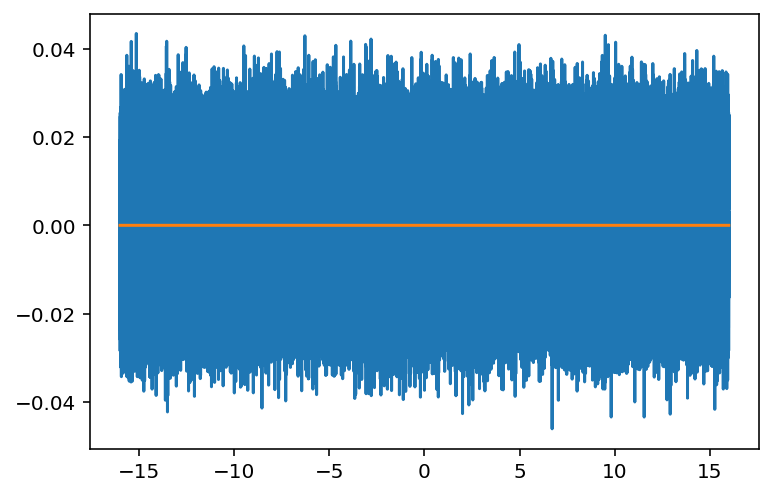

In [9]:
signalH_noise = qnm_filter.bilby_get_strain(bilby_ifo)
signalH_no_noise = qnm_filter.bilby_get_strain(bilby_ifo_no_noise)
signalH_noise.plot()
signalH_no_noise.plot()

### Inject the GW strain into noise

In [10]:
def NR_injection_into_Bilby(time, **waveform_kwargs):
    hplus_interp_func = interp1d(t_range, signal, bounds_error=False, fill_value=0)
    hcross_interp_func = interp1d(t_range, signal, bounds_error=False, fill_value=0)
    hplus = hplus_interp_func(time)
    hcross = hcross_interp_func(time)
    return {'plus': hplus, 'cross': hcross}

*Below parameters are needed by `Bilby`, although they are not really used by the code*

In [11]:
injection_parameters = dict(mass_1=50, mass_2=50,
                            spin_1x=0, spin_1y=0, spin_1z=0,
                            spin_2x=0, spin_2y=0, spin_2z=0,
                            geocent_time=-duration/2,
                            ra=0, dec=0, psi=0)

bilby_ifo.minimum_frequency = 10
bilby_ifo_no_noise.minimum_frequency = 10

In [12]:
bilby_ifo_inj = qnm_filter.bilby_injection(bilby_ifo, NR_injection_into_Bilby, **injection_parameters)
bilby_ifo_inj_no_noise = qnm_filter.bilby_injection(bilby_ifo_no_noise, NR_injection_into_Bilby,
                                                    **injection_parameters)

08:59 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: None
  time_domain_source_model: __main__.NR_injection_into_Bilby
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
08:59 bilby INFO    : Generation of source frame parameters failed with message 'luminosity_distance'
08:59 bilby INFO    : Injected signal in None:
08:59 bilby INFO    :   optimal SNR = 185.99
08:59 bilby INFO    :   matched filter SNR = 185.72+0.51j
08:59 bilby INFO    :   mass_1 = 50
08:59 bilby INFO    :   mass_2 = 50
08:59 bilby INFO    :   spin_1x = 0
08:59 bilby INFO    :   spin_1y = 0
08:59 bilby INFO    :   spin_1z = 0
08:59 bilby INFO    :   spin_2x = 0
08:59 bilby INFO    :   spin_2y = 0
08:59 bilby INFO    :   spin_2z = 0
08:59 bilby INFO    :   geocent_time = -16.0
08:59 bilby INFO    :   ra = 0
08:59 bilby INFO    :   dec = 0
08:59 bilby INFO    :   psi = 0
08:59 bilby INFO    : Waveform generator initiated with
  frequency_domain_so

In [13]:
signalH = qnm_filter.bilby_get_strain(bilby_ifo_inj)
signalH_no_noise = qnm_filter.bilby_get_strain(bilby_ifo_inj_no_noise)

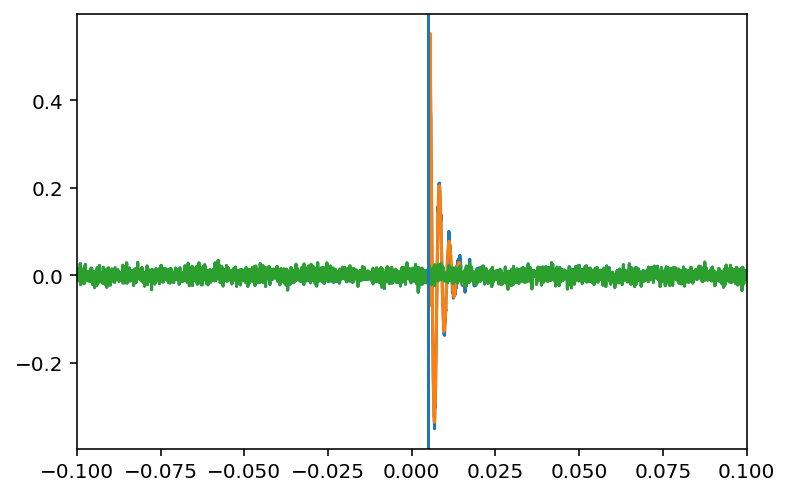

In [14]:
signalH.plot()
signalH_no_noise.plot()
signalH_noise.plot()
pl.xlim(-0.1,0.1)
pl.axvline(0.005)

### Ringdown analysis with rational filter(s)

In [15]:
t_init = 0.003
srate = 4096.
fit = qnm_filter.Network(window_width=0.2, srate = srate, t_init=t_init)

In [16]:
fit.original_data['H1'] = signalH
fit.detector_alignment(t_init = t_init)

In [17]:
fit.pure_noise = {}
fit.pure_noise['H1'] = signalH_noise

We use the Welch method to estimate the covariance matrix with pure noise. The estimation with `original_data` may break down when SNR is large enough

In [18]:
fit.condition_data('original_data')
fit.condition_data('pure_noise')
fit.compute_acfs('pure_noise')

In [19]:
fit.cholesky_decomposition()

Sampling remnant mass and spin

In [20]:
delta_mass = 2.0
delta_chi = 0.03
massspace = np.arange(30, 70, delta_mass)
chispace = np.arange(0.0, 0.95, delta_chi)
mass_grid, chi_grid = np.meshgrid(massspace, chispace)

Compute the first index of the analysis window

In [21]:
fit.first_index()
index_spacing = 2
num_iteration = 15
initial_offset = 0

In [22]:
fitnew=copy.deepcopy(fit)

Iterate over `t_init`

In [23]:
t_array, saved_log_evidence = qnm_filter.evidence_parallel(fit, index_spacing, num_iteration, 
                                                           initial_offset, massspace, chispace, num_cpu = -1, 
                                                           verbosity=False, model_list = [(2, 2, 0)])

In [24]:
t_array_no_filter, saved_log_evidence_no_filter = qnm_filter.evidence_parallel(fitnew, index_spacing, num_iteration, 
                                                                               initial_offset, massspace, chispace, 
                                                                               num_cpu = -1, verbosity=False, 
                                                                               apply_filter=False, 
                                                                               model_list = [(2, 2, 0)])

In the absence of the filter, the curve goes up when the ringdown signal slides off the analysis window, namely $t>t_{\rm start\, time}$. In contrast, the filter flips the ringdown to the oppsite side, causing the evidence curve to rise sooner and plateau when $t>t_{\rm start\, time}$.

In [25]:
saved_log_evidence /= np.log(10) # ln to lg
saved_log_evidence_no_filter /= np.log(10)

Text(0.5, 0, 't (ms)')

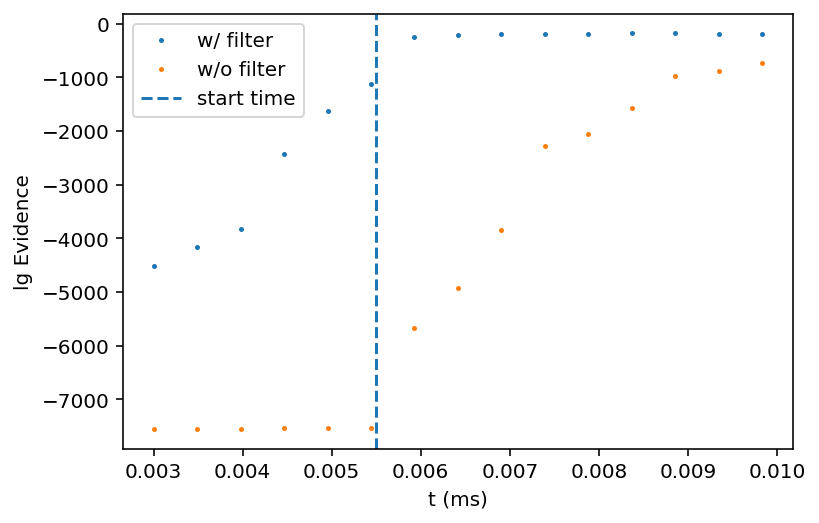

In [26]:
pl.plot(t_array, saved_log_evidence, 'o', ms=1.5, label='w/ filter')
pl.plot(t_array_no_filter, saved_log_evidence_no_filter, 'o', ms=1.5, label="w/o filter")
pl.axvline(signalH_no_noise.time[signalH_no_noise.argmax()], ls='--', label='start time')
pl.legend()
pl.ylabel('lg Evidence')
pl.xlabel('t (ms)')

The difference between the two evidence curves leads to the Bayes factor of the QNM, which peaks at its start time.

Text(0.5, 0, 't (ms)')

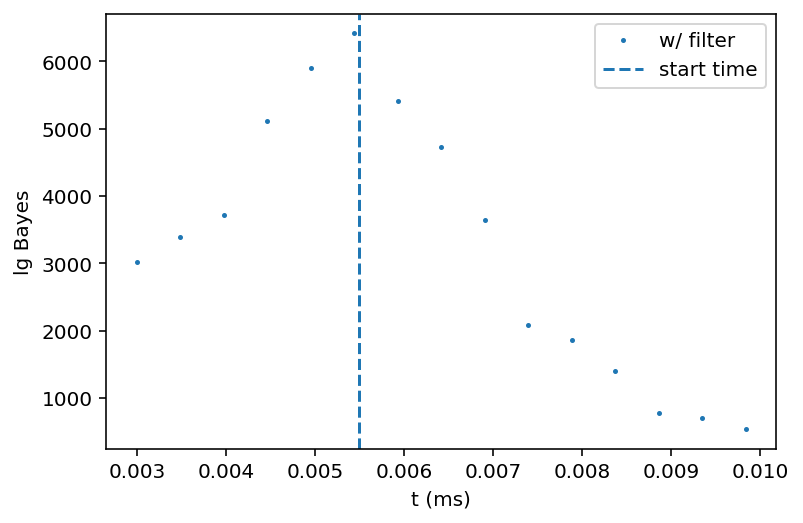

In [27]:
pl.plot(t_array, saved_log_evidence-saved_log_evidence_no_filter, 'o', ms=1.5, label='w/ filter')
pl.axvline(signalH_no_noise.time[signalH_no_noise.argmax()], ls='--', label='start time')
pl.legend()
pl.ylabel('lg Bayes')
pl.xlabel('t (ms)')